### Introduction ###

Fraud has become an ever-rising concern, especially in the UK with PWC reporting that in 2022, fraudsters stole £1.2bn __(PWC, 2023)__. With an alarmingly high figure, the need for a machine learning model to accurately identify fraudulent transactions will not only protect customers from becoming victims of fraud, but also reduce the amount financial instituations e.g. insurance companies needing to pay comepensation to these victims.

Kaggle provided a dataset of just over a million records of transactions detailing the type of transaction e.g. payment, cash outgoing, transfers; the transaction amount, the source account name, the old balance of the source account, the new balance of the source account, the destination account name, the old balance of the destination account, the new balance of the destination account, a binary flag on whether the transaction was fraudulent or not, and a flag on whether the transaction was marked as fraudulent or not __(Lopez-Rojas, 2016)__. I will extract a much smaller subset of the data set to avoid overfitting and, using a decision tree classification model, I will train my model to predict whether a transaction is fraudulent or not.


**PWC. (2023). UK Banking Fraud Sentiment Index. [online] Available at: https://www.pwc.co.uk/forensic-services/assets/documents/uk-banking-fraud-sentiment-index.pdf [Accessed 18 Oct. 2024].**

**Lopez-Rojas, E. (2016). Synthetic Financial Datasets For Fraud Detection. [online] Kaggle.com. Available at: https://www.kaggle.com/datasets/ealaxi/paysim1 [Accessed 18 Oct. 2024].**

‌

‌

In [262]:
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score


# 1: Extracting Data from Dataset

In [267]:
# Fraud detection in bank accounts
dataset = pd.read_csv('PS_20174392719_1491204439457_log.csv')

### Issue: Skewed Dataset
Upon manually analysing the dataset via excel, I discovered that only 0.1% of the transactions in the dataset were marked as fraudulent which, although is an accurate representation of the proportion of transactions in real-life that are fraudulent, this would have been a poor proportion to train my model on, as shown when I trained my model on 3500 items from the data set at this proportion and found that the f1 score was 25%. 

I adjusted the dataset that I would feed into my model to contain 30% fraudulent results and 70% non-fraudulent results and will confirm that my model works well on this data via the confusion matrix I will create later in the code. 

Due to the nature of this dataset, a confusion matrix is essential for analysis - without doing this, I run the risk of creating a model which is seemingly highly accurate, with very high true negative predictions (i.e. non-fraudulent) but many false positive predicitions and near-zero true negative predictions.

In [266]:
fraudulent_data = dataset[dataset['isFraud'] == 1]
non_fraudulent_data = dataset[dataset['isFraud'] == 0]
print(fraudulent_data.shape)

# 30% of total data set is fraudulent
fraudulent_data = fraudulent_data[:1050]

#70% of total data set is non-fraudulent
non_fraudulent_data = non_fraudulent_data[:2450]

# 3500 total data points
proportionate_dataset = pd.concat([fraudulent_data, non_fraudulent_data],ignore_index=True)

proportionate_dataset = proportionate_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# proportionate_dataset = dataset[:3000] # here is the line that drops f1 score


(8213, 11)


In [168]:
proportionate_dataset[proportionate_dataset['isFraud'] == 1].size


11550

In [169]:
# (rows, columns)
# Confirm dataset looks as expected
proportionate_dataset.shape

(3500, 11)

# 2: Creating Train & Test Subsets

In [265]:
# Split dataset into train and test
# input
x = proportionate_dataset.drop("isFraud", axis='columns')

# output
y = proportionate_dataset["isFraud"]

# Remove obselete columns
x = x.drop(["nameOrig", "nameDest"], axis="columns")

Below, I will split the data into a train and test sets and utilise the stratify parameter to ensure that the proportions of fraudulent and non-fraudulent data in each sub set is the same 

In [172]:
# Split data into training and testing sets using stratify param to ensure proportion of fraudulent to non-fraudulent transactions is equal
x_train,x_test,y_train,y_test = train_test_split(x,y, stratify=y)


In [173]:
print(x_train.shape)
print(x_test.shape)

(2625, 8)
(875, 8)


# 3. Visualise Data

[]

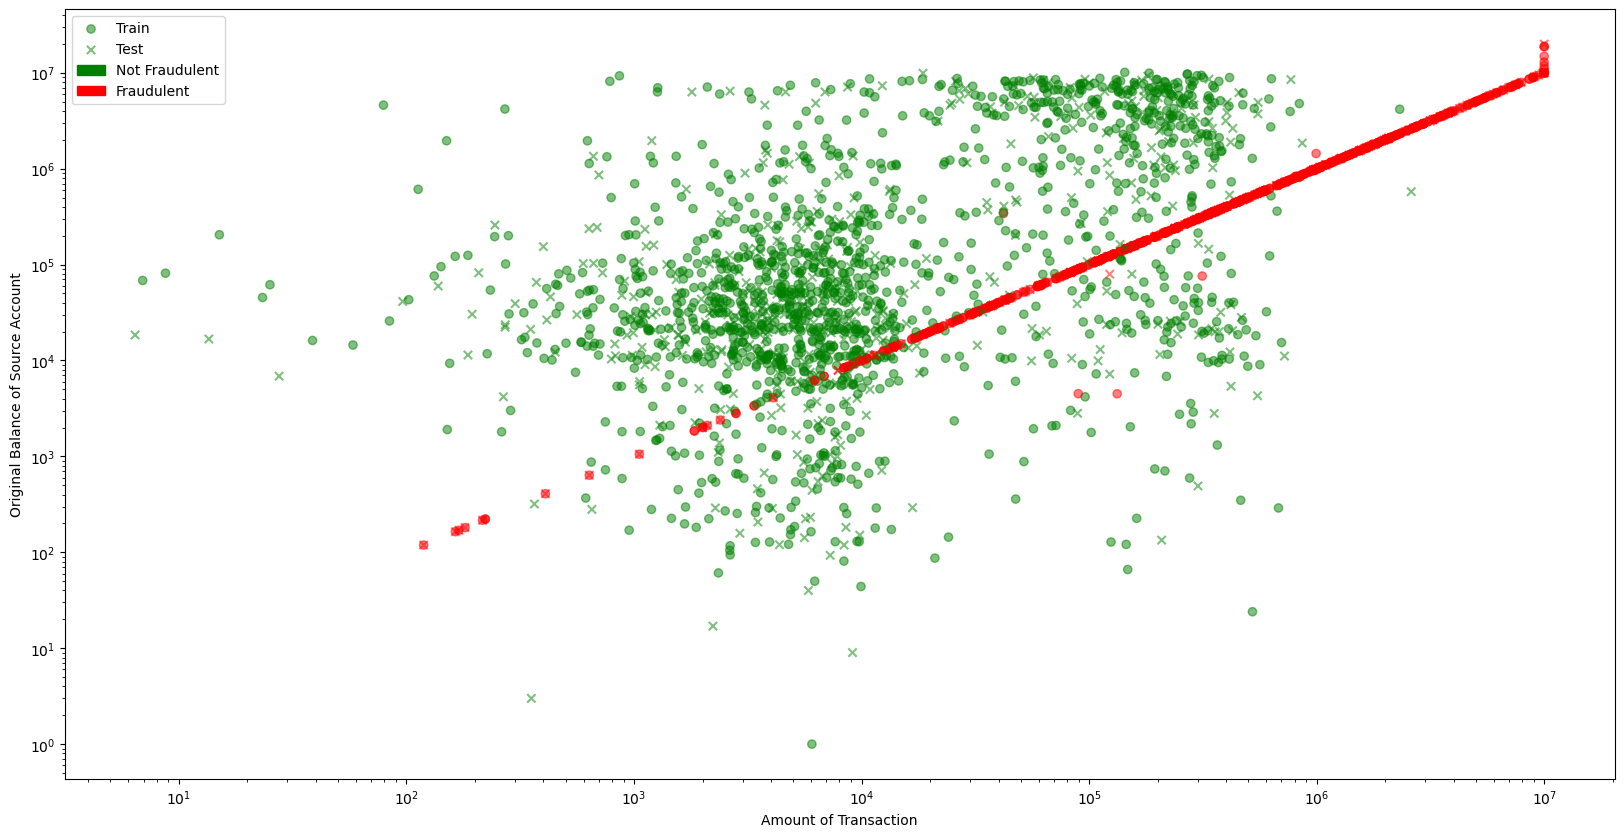

In [174]:
plt.figure(figsize=(20,10))
colourMap = colors.ListedColormap(['green', 'red'])

plt.scatter(x_train["amount"], x_train["oldbalanceOrg"], c=y_train, cmap=colourMap, alpha = 0.5, label="Train", marker="o" )
plt.scatter(x_test["amount"], x_test["oldbalanceOrg"], c=y_test, cmap=colourMap, alpha = 0.5, label="Test", marker="x")

plt.ylabel("Original Balance of Source Account")
plt.xlabel("Amount of Transaction")

plt.yscale('log')
plt.xscale('log')

plt.legend() 
redPatch = mpatches.Patch(color='green', label='Not Fraudulent')
greenpatch = mpatches.Patch(color='red', label='Fraudulent')
    
ax = plt.gca()
leg = ax.get_legend()
plt.legend(handles=[leg.legend_handles[0],leg.legend_handles[1], redPatch, greenpatch])

plt.plot()


#### Figure 1 - Scatter Plot of Dataset

Figure 1 is a scatter graph that illustrates the relationship between the original balance of the source account, and the transacted amount. It reveals that the majority of fraudulent transactions occur when the original balance of the source account closely matches the transaction amount indicating that a transaction is most likely fraudulent when nearly the entire balance of the account is being transferred or withdrawn.

### Issue: Poor Outlier Prediction 
The results from my first iteration of predictions were phenomenal, with the model having 99.4% and 99.8% accuracy on the training and test data predictions respectively and only displaying 1 false negative in a dataset of 2000 items, however, one thing I noted from observing figure 1 is that the model was trained mostly on standard data, and ran into very few outliers, so its performance on outlier classification was not able to be judged. I then decided to inject a significant amount of outliers deliberately into both the train and test sets of data before retraining the model


In [268]:
# Seperate all non-fraudulent data and fraudulent data from complete dataset
fraudulent_data = dataset[dataset['isFraud'] == 1]
non_fraudulent_data = dataset[dataset['isFraud'] == 0]

In [269]:
# Extract outliers where the amount transferred is substantially greater than the original balance of the source account
def extract_outliers_high(dataset, threshold):
    outliers = dataset[dataset['amount'] > threshold * dataset['oldbalanceOrg']]
    return outliers

# Extract outliers where the amount transferred is substantially less than the original balance of the source account
def extract_outliers_low(dataset, threshold):
    outliers = dataset[dataset['amount'] < dataset['oldbalanceOrg'] / threshold]
    return outliers

# Extract outliers from all fraudulent data
fraudulent_outliers_hi = extract_outliers_high(fraudulent_data, 1.5)
fraudulent_outliers_lo = extract_outliers_low(fraudulent_data, 1.5)


In [270]:

# Dataframe containing all fraudulent outliers
outliers = pd.concat([fraudulent_outliers_hi, fraudulent_outliers_lo],ignore_index=True)

# Shuffle the outliers data set
outliers = outliers.sample(frac=1, random_state=42).reset_index(drop=True)

# get number of rows in outliers dataframe
print(len(outliers))

# Split outliers into training and testing sets 
train_outliers = outliers[len(outliers)//2:]
test_outliers = outliers[:len(outliers)//2]

117


Aim here is to drop x rows from the existing dataset being fed to the model where x is the number of outliers identified so that these outliers can be injected into the model

In [271]:
# Join outliers with the proportionate dataset
# Drop x rows from current dataset where the transaction is fraudulent with x being the length of the outliers dataset
rows_to_drop = proportionate_dataset[proportionate_dataset['isFraud'] == 1].index

rows_to_drop = rows_to_drop[:len(outliers)]

# Drop rows_to_drop number of rows from the dataset fed into model
proportionate_dataset2 = proportionate_dataset.drop(rows_to_drop)

# Evenly split dataset into training and testing sets
train_proportionate_dataset = proportionate_dataset2[len(proportionate_dataset2)//2:]
test_proportionate_dataset = proportionate_dataset2[:len(proportionate_dataset2)//2]

# Evenly split outliers into training and testing sets
train_data = pd.concat([train_proportionate_dataset, train_outliers],ignore_index=True)
test_data = pd.concat([test_proportionate_dataset, test_outliers],ignore_index=True)


In [272]:
# Split the data intended for training into input and output
#input
x_for_train = train_data.drop("isFraud", axis='columns')

#output
y_for_train = train_data["isFraud"]

# Remove obselete columns
x_for_train = x_for_train.drop(["nameOrig", "nameDest"], axis="columns")

x_train1,x_test1,y_train1,y_test1 = train_test_split(x_for_train,y_for_train, stratify=y_for_train)



In [273]:
# Split the data intended for testing into input and output
#input
x_for_test = test_data.drop("isFraud", axis='columns')

#output
y_for_test = test_data["isFraud"]

# Remove obselete columns
x_for_test = x_for_test.drop(["nameOrig", "nameDest"], axis="columns")

x_train2,x_test2,y_train2,y_test2 = train_test_split(x_for_test,y_for_test, stratify=y_for_test)

In [274]:
# Join the two sets of splits 
x_train = pd.concat([x_train1, x_train2],ignore_index=True)
x_test = pd.concat([x_test1, x_test2],ignore_index=True)
y_train = pd.concat([y_train1, y_train2],ignore_index=True)
y_test = pd.concat([y_test1, y_test2],ignore_index=True)

[]

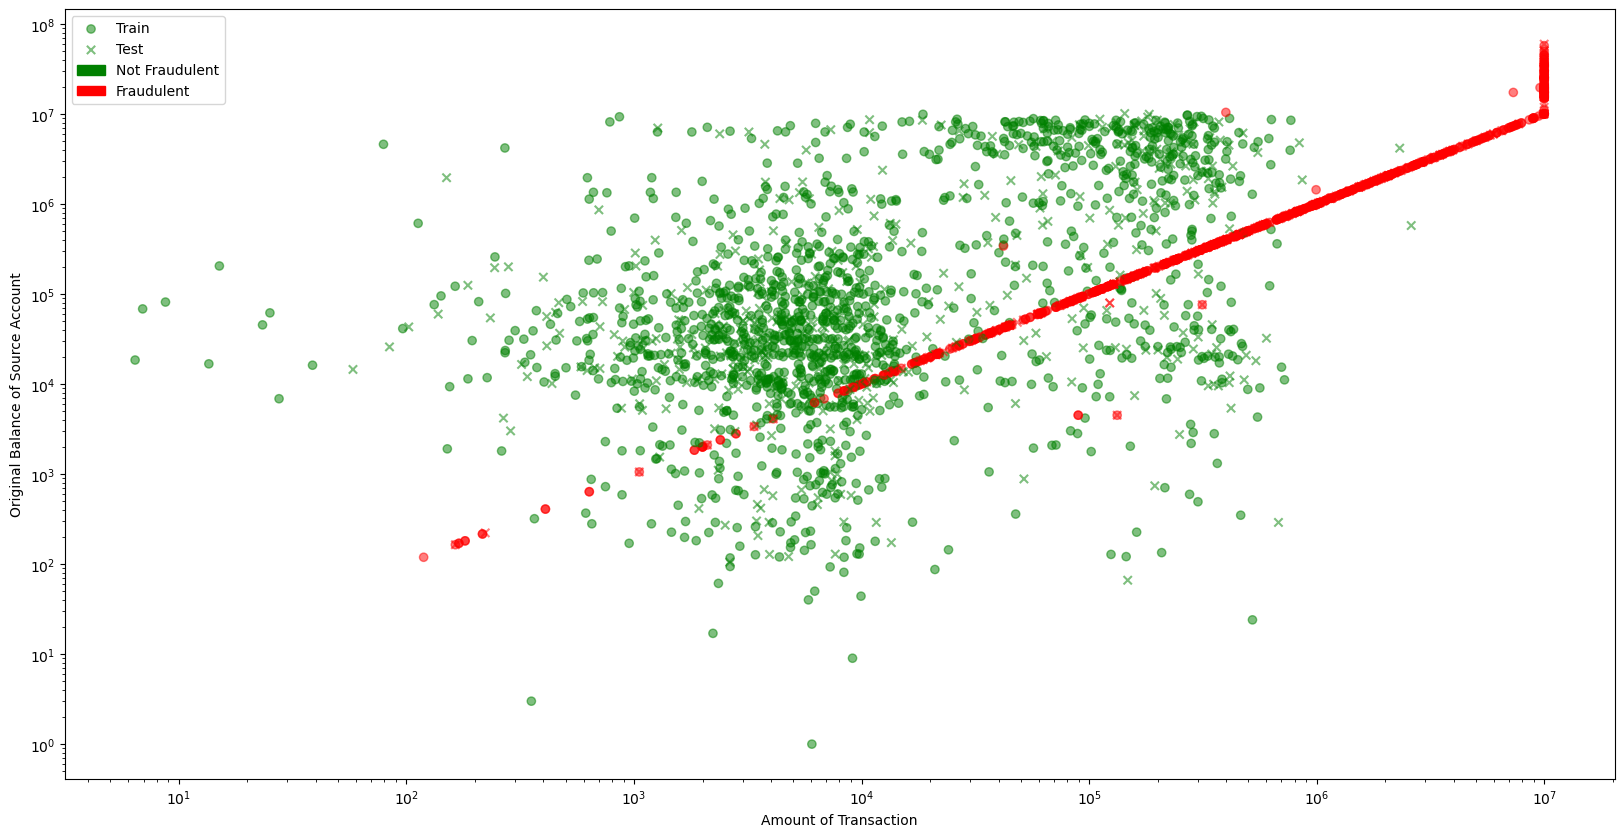

In [275]:
plt.figure(figsize=(20,10))
colourMap = colors.ListedColormap(['green', 'red'])

plt.scatter(x_train["amount"], x_train["oldbalanceOrg"], c=y_train, cmap=colourMap, alpha = 0.5, label="Train", marker="o" )
plt.scatter(x_test["amount"], x_test["oldbalanceOrg"], c=y_test, cmap=colourMap, alpha = 0.5, label="Test", marker="x")

plt.ylabel("Original Balance of Source Account")
plt.xlabel("Amount of Transaction")

plt.yscale('log')
plt.xscale('log')

plt.legend() 
redPatch = mpatches.Patch(color='green', label='Not Fraudulent')
greenpatch = mpatches.Patch(color='red', label='Fraudulent')
    
ax = plt.gca()
leg = ax.get_legend()
plt.legend(handles=[leg.legend_handles[0],leg.legend_handles[1], redPatch, greenpatch])

plt.plot()


## Figure 2

Figure 2 shows the new split of data on my model, with an equal number of outliers in both the train and test set, and as hypothesized above, the results observed in the confusion matrix now worsen, with the number of false negatives increasing to 7 (was 1) and the number of false positives increasing to 2 (was 0). The accuracy scores also change, with the train accuracy increasing to 99.7% and the test accuracy decreasing to 98.9%.

The next logical step after this is to finetune the hyperparameters to improve the results

# 4. Train Model

In [278]:
label_encoder = LabelEncoder()

# # Create Classifier Model
# decision_tree_model = DecisionTreeClassifier(random_state=42)  

### Issue: String to int conversion
// explain why fit transform is needed and what the data looked like pre conversion etc



In [279]:
# transform needed to convert string vals in CSV column to numbers as model cannot train on strings
x_train['type'] = label_encoder.fit_transform(x_train['type'])

# transform used again but NOT fit_transform because you want to test on the same transformation done on train set
x_test['type'] = label_encoder.transform(x_test['type'])

In [280]:
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [281]:
from sklearn.model_selection import GridSearchCV


grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
                           param_grid=param_grid,
                           cv=5, 
                           scoring='accuracy')

In [282]:
grid_search_dt.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [285]:
print("Best Parameters:", grid_search_dt.best_params_)
print("Best Cross-Validation Score:", grid_search_dt.best_score_)

# Get best decision tree model
dt_model = grid_search_dt.best_estimator_

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Cross-Validation Score: 0.9946637586332242


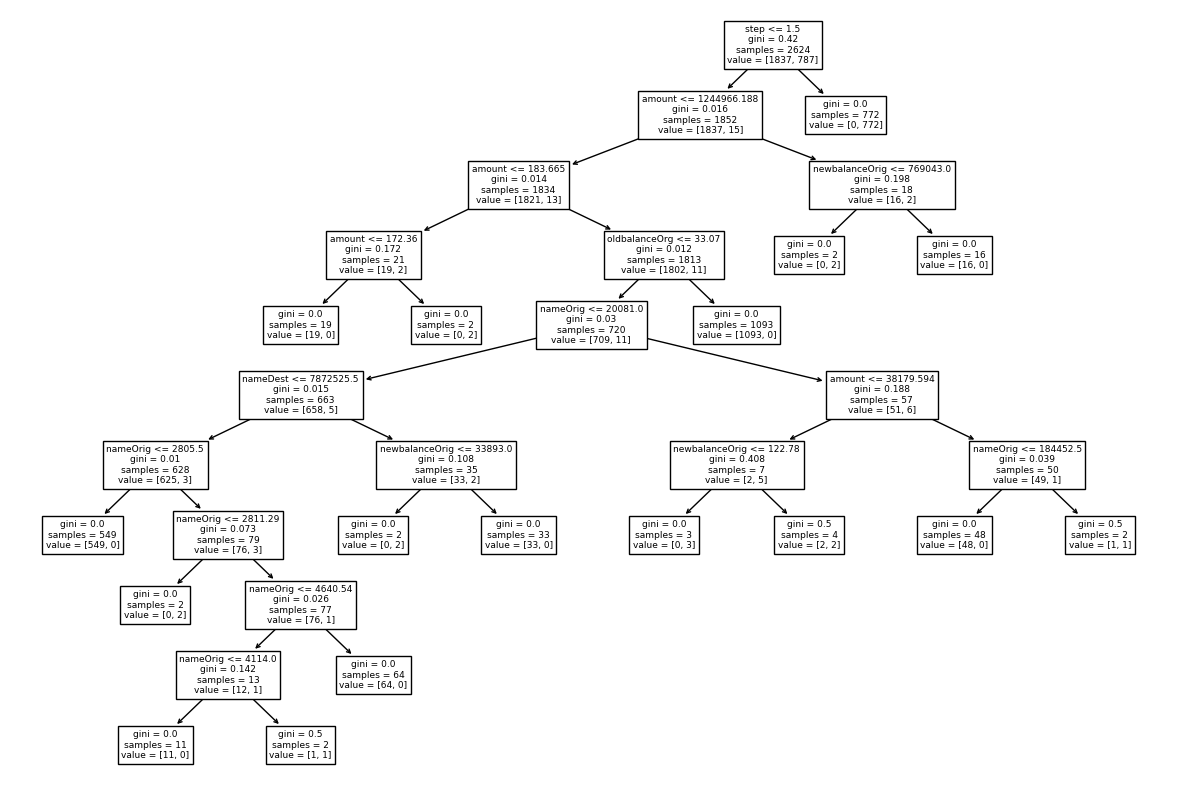

In [289]:
# Visualise the decision tree
plt.figure(figsize=(15,10))
plot_tree(dt_model, feature_names=["step","type","amount","nameOrig","oldbalanceOrg","newbalanceOrig","nameDest","oldbalanceDest","newbalanceDest","isFraud","isFlaggedFraud"])
plt.show()

### Figure 2 - Decision Tree


# 5. Test Model Predictions

In [290]:
# Prediction on train data
y_train_prediction = dt_model.predict(x_train)

# Prediction on test data
y_test_prediction = dt_model.predict(x_test) 

# Generate accuracy scores for train and test data
y_test_accuracy_score = accuracy_score(y_test, y_test_prediction)
y_train_accuracy_score = accuracy_score(y_train, y_train_prediction)

# Print accuracy scores for train and test data
print("Train data accuracy: ", y_train_accuracy_score)
print("Test data accuracy: ", y_test_accuracy_score)

Train data accuracy:  0.9984756097560976
Test data accuracy:  0.9954337899543378


// When analysing the models performance against the test data, it shows that 

# 6. Analysing Preidction Results

Number of True Negatives: 612.000
Number of True Positives: 260.000
Number of False Negatives: 3.000
Number of False Positives: 1.000


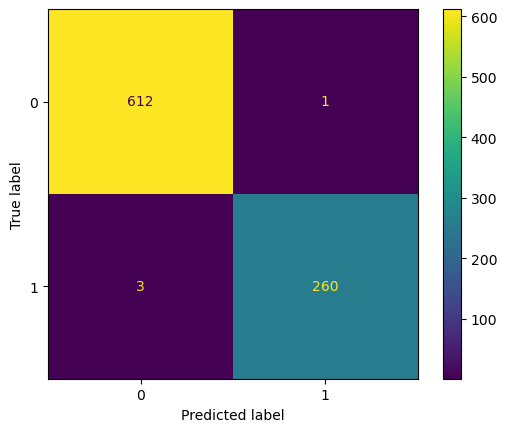

In [292]:
# Generate confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,y_test_prediction, labels=dt_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=dt_model.classes_)

# Display confusion matrix
disp.plot()

# Print confusion matrix values
print("Number of True Negatives: {:.3f}".format(confusion_matrix[0,0]))
print("Number of True Positives: {:.3f}".format(confusion_matrix[1,1]))
print("Number of False Negatives: {:.3f}".format(confusion_matrix[1,0]))
print("Number of False Positives: {:.3f}".format(confusion_matrix[0,1]))

### Figure 3 - Confusion Matrix

### Model Performance Analysis
///
The model seemingly performed incredibly well, with its test accuracy being 99.8%, with it only recording 1 false negative and no false positives. This performance could be attributed to the underlying patterns in the data, as shown in figure 1. The fraudulent transactions appear to follow a distinct linear trend, making it easier for the model to accurately predict instances of fraud. As a result, the linear characteristics of the data likely enhance the model's ability to differentiate between fraudulent and non-fraudulent transactions effectively.


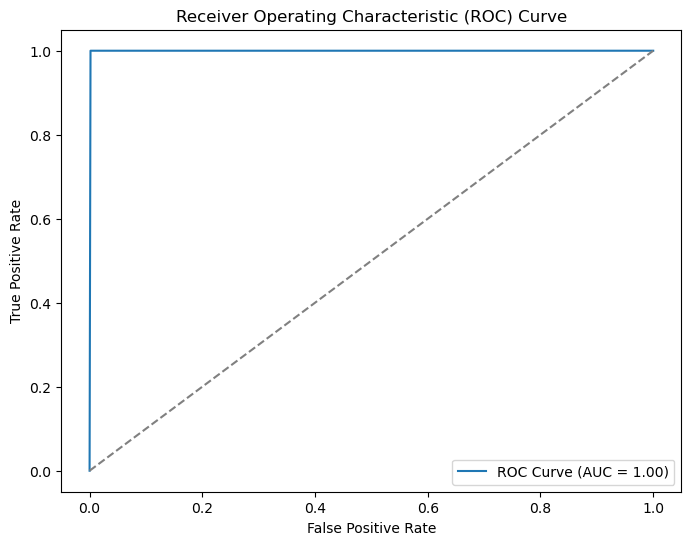

In [293]:
# Get the probability of the positive class (i.e. Fraudulent transactions)
y_probs = dt_model.predict_proba(x_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
auc_score = metrics.roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")

# Plot the random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")

plt.legend(loc="lower right")
plt.show()

### Figure 4 - ROC Curve

In [294]:
f1 = metrics.f1_score(y_test, y_test_prediction)
precision = metrics.precision_score(y_test, y_test_prediction)
recall = metrics.recall_score(y_test, y_test_prediction)

print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")    
print(f"Recall: {recall:.2f}")

F1 Score: 0.99
Precision: 1.00
Recall: 0.99


# K-Nearest Neighbours

# Grid search implementation (TBD)

In [295]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],   # Number of neighbors
    'weights': ['uniform', 'distance'], # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'leaf_size': [10, 20, 30]           # Leaf size passed to the underlying algorithms
}

In [297]:
from sklearn.neighbors import KNeighborsClassifier


grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy'
)

In [298]:
grid_search_knn.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [299]:
print(grid_search_knn.best_score_)
print(grid_search_knn.best_params_)

0.951598691384951
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'weights': 'distance'}


In [303]:
knn_model = grid_search_knn.best_estimator_
print(knn_model)

KNeighborsClassifier(leaf_size=10, n_neighbors=7, weights='distance')


In [304]:
y_train_prediction_knn = knn_model.predict(x_train)
y_test_prediction_knn = knn_model.predict(x_test)

print("train accuracy: ", accuracy_score(y_train, y_train_prediction_knn))
print("test accuracy: ", accuracy_score(y_test, y_test_prediction_knn))

train accuracy:  1.0
test accuracy:  0.954337899543379


Number of True Negatives: 588.000
Number of True Positives: 248.000
Number of False Negatives: 15.000
Number of False Positives: 25.000


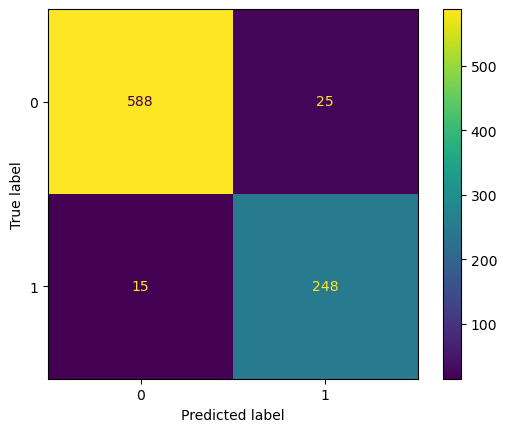

In [305]:
# Generate confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,y_test_prediction_knn, labels=knn_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=knn_model.classes_)

# Display confusion matrix
disp.plot()

# Print confusion matrix values
print("Number of True Negatives: {:.3f}".format(confusion_matrix[0,0]))
print("Number of True Positives: {:.3f}".format(confusion_matrix[1,1]))
print("Number of False Negatives: {:.3f}".format(confusion_matrix[1,0]))
print("Number of False Positives: {:.3f}".format(confusion_matrix[0,1]))

In [306]:
f1 = metrics.f1_score(y_test, y_test_prediction_knn)
precision = metrics.precision_score(y_test, y_test_prediction_knn)
recall = metrics.recall_score(y_test, y_test_prediction_knn)

print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")    
print(f"Recall: {recall:.2f}")


F1 Score: 0.93
Precision: 0.91
Recall: 0.94
